This notebook reads in a selected region of SLCs, creates interferograms with them, and outputs the igram as an ISCE-readable file for using with SNAPHU. 


This notebook:
1. Reads in 2 SLCs in specific region defined, interferes them, filters it, unwraps it.
2. Reads in same 2 SLCs, interferes them, downlooks them, unwraps it, upsamples it.
3. I used these to compare computation time of each. Method two is A LOT faster.
4. Plots unwrapped interferogram results from both methods, compare. Making sure they give same results.

This notebook was written on 10-18-23

***
***

In [1]:
import os,sys
import glob
import pandas as pd
import math
from osgeo import gdal
import numpy as np
from array import array
from scipy  import signal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

import isce
import isceobj
from contrib.Snaphu.Snaphu import Snaphu

import shutil
from imageMath import IML
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# Larger area 
outputdir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/'

# size of full res SLCs
dxIN=18000
dyIN=3600

# load in dates
dates = [os.path.basename(x) for x in glob.glob(workdir+"SLC_vv/2*")]
dates = sorted(dates)
print(dates)

# larger cropped region
x1 = 18000
y1 = 2100
x2 = 14000
y2 = 1000
dx = x1-x2
dy = y1-y2

alooks=4
rlooks=20

['20170510', '20170522', '20170603', '20170615', '20170627', '20170709', '20170721', '20170802', '20170814', '20170826', '20170907', '20170919', '20171013', '20171025', '20171106', '20171118', '20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180704', '20180716', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190629', '20190711', '20190723', '20190804', '20190816', '20190822', '20190828', '20190903', '20190909', '20190915', '20190921', '20190927', '20191003', '20191009', '20191015', '20191021', '20191027', '20191102', '20191108', '20191114', '20

Spatially filter, then unwrap.

In [3]:
# read in two SLCs (loop through them later), make igram, output it as a temporary file

driver=gdal.GetDriverByName('ISCE')

# select which pair of SLCs (seq interferogram) we want to test unwrapping.
i=123
date1 = dates[i]
date2 = dates[i+1]

# load the SLCs 
ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('SLC 1 subsection loaded.')
ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
print('SLC 2 subsection loaded.')
intTemp = (slc1*np.conj(slc2))
# save the file 
colds = driver.Create(outputdir+'igram_temp.r4',dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(np.angle(intTemp))
colds=None

# filter the interferogram 
filtimager=gaussian_filter(np.real(intTemp), sigma=[alooks/4,rlooks/4])
filtimagei=gaussian_filter(np.imag(intTemp), sigma=[alooks/4,rlooks/4])
filt_intTemp = filtimager+1j*filtimagei
print('igram filtered.')

# save the file 
colds = driver.Create(outputdir+'filt_igram_temp.r4',dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(np.angle(filt_intTemp))
colds=None
print('temp filt igram saved.')

# unwrap filt interferogram
outfile = outputdir+'filt_unwrapped_igram_temp.r4'
inputFilename = outputdir+'filt_igram_temp.r4'
# use SNAPHU to unwrap 
snaphu = Snaphu()
snaphu.setInput(inputFilename)
snaphu.setOutput(outfile)
snaphu.setWidth(dx) # this was 4800 for Rowena's test 
snaphu.setCostMode('DEFO') # try SMOOTH, was DEFO to start
snaphu.setEarthRadius(6356236.24233467)
snaphu.setWavelength(0.0562356424)
snaphu.setAltitude(788151.7928135)
snaphu.setCorFileFormat('FLOAT_DATA')
snaphu.setIntFileFormat('FLOAT_DATA')
snaphu.setUnwFileFormat('FLOAT_DATA')
print("Preparing")
snaphu.prepare()
snaphu.unwrap()
print('Unwrapped.')
copyThisFile = outputdir+'igram_temp.r4.xml'
putItHere = outputdir+'filt_unwrapped_igram_temp.r4.xml'
# copy the xml file so the new one can be read.
shutil.copy(copyThisFile,putItHere)

SLC 1 subsection loaded.
SLC 2 subsection loaded.
igram filtered.
temp filt igram saved.
Preparing
Unwrapped.

snaphu v1.4.2
Reading wrapped phase from file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/filt_igram_temp.r4
No weight file specified.  Assuming uniform weights
No correlation file specified.  Assuming correlation = 0.01
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Growing connected component mask
Writing connected components to file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/filt_unwrapped_igram_temp.r4.conncomp
Maximum flow on network: 1
Total solution cost: 39351
Integrating phase
Writing output to file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/filt_unwrapped_igram_temp.r

'/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/filt_unwrapped_igram_temp.r4.xml'

Load in the files just made.

In [4]:
# Now that I've tested one, load in the file and plot it. 
f1 = gdal.Open(outputdir+'filt_igram_temp.r4', gdal.GA_ReadOnly)
filt_igram = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(outputdir+'filt_unwrapped_igram_temp.r4', gdal.GA_ReadOnly)
unwr_filt_igram = f1.ReadAsArray()
f1 = None

Plot them.

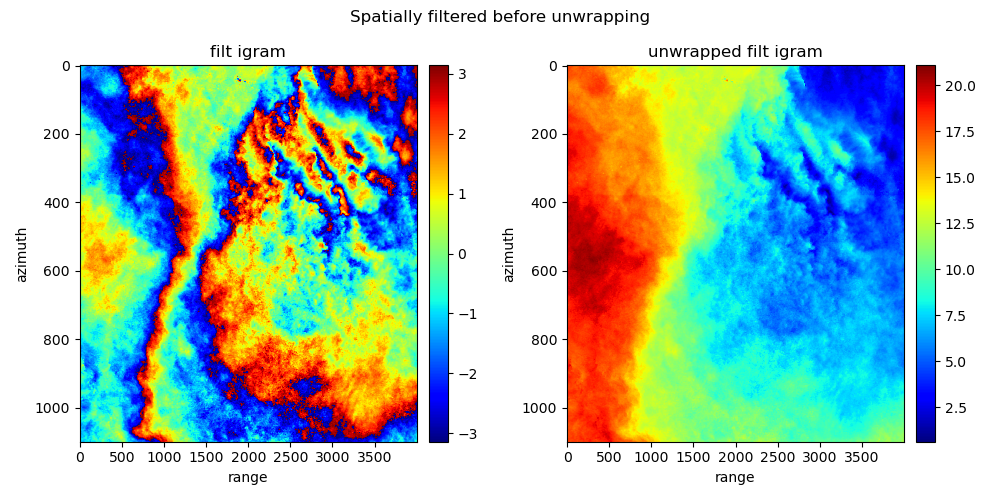

In [5]:
# now plot them
fig = plt.figure(figsize=(10,5),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.imshow(np.fliplr(filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(1,2,2)
plt.imshow(np.fliplr(unwr_filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.suptitle('Spatially filtered before unwrapping')
plt.show()

Now downlook, then unwrap, then upsample again.

200 275
size of downlooked images: 275,200
igram downlooked.


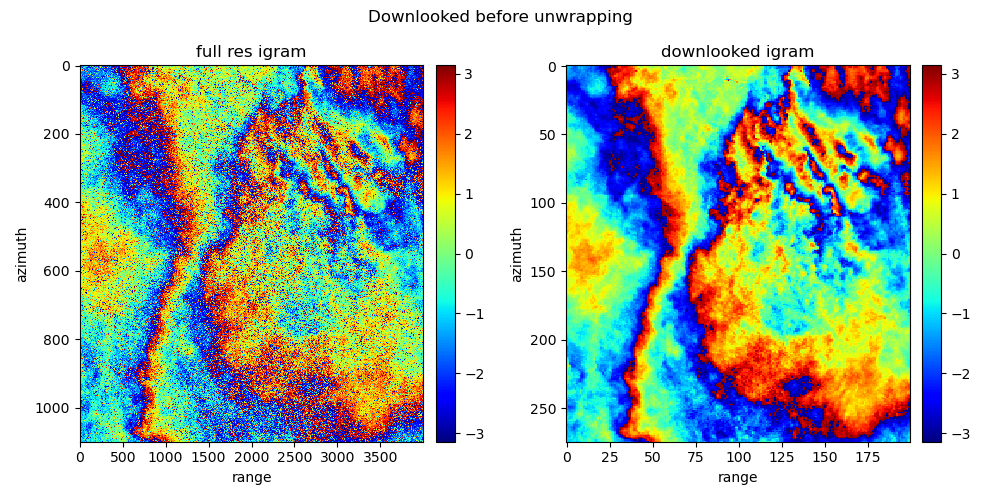

temp downlooked igram saved.
Preparing

snaphu v1.4.2
Reading wrapped phase from file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/dl_igram_temp.r4
Unwrapped.
No weight file specified.  Assuming uniform weights
No correlation file specified.  Assuming correlation = 0.01
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 1
Flow increment: 1  (Total improvements: 0)
Growing connected component mask
Writing connected components to file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/dl_unwrapped_igram_temp.r4.conncomp
Maximum flow on network: 1
Total solution cost: 63264
Integrating phase
Writing output to file /data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/dl_unwrapped_igram_temp.r4


'/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/cropped_LS_with_western_mtns/dl_unwrapped_igram_temp.r4.xml'

In [6]:
# this is all commented out becuase it's the same as before: we want to use the same SLCs
# left the code here becuase I needed it when I wanted to directly compare computation time between filt->unwrap and downlook->unwrap->uplook 


#driver=gdal.GetDriverByName('ISCE')
# # select which pair of SLCs (seq interferogram) we want to test unwrapping.
# i=3
# date1 = dates[i]
# date2 = dates[i+1]
# # read in two SLCs (loop through them later), make igram, output it as a temporary file
# #load the SLCs 
# ds = gdal.Open(workdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
# slc1 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
# print('SLC 1 subsection loaded.')
# ds = gdal.Open(workdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
# slc2 = ds.GetRasterBand(1).ReadAsArray(x2,y2,dx,dy)
# print('SLC 2 subsection loaded.')
# intTemp = (slc1*np.conj(slc2))
# # save the file 
# colds = driver.Create(outputdir+'igram_temp.r4',dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(np.angle(intTemp))
# colds=None

# downlook 
if dx/rlooks%1 != 0 or dy/alooks%1 != 0:
    print('Igram dimensions are not divisible by downlooking window')
dxdl = int(dx/rlooks)
dydl = int(dy/alooks)
print(dxdl,dydl)
print('size of downlooked images: '+str(dydl)+','+str(dxdl))
dlint = np.ndarray((dydl,dxdl),dtype='float')
for y in range(dydl): #dydl
    for x in range(dxdl): #dxdl
        # average over each window by taking complex sum and angle of that 
        dlint[y,x] = np.angle(np.sum(intTemp[y*alooks:(y+1)*alooks,x*rlooks:(x+1)*rlooks]))
print('igram downlooked.')

# plot to test if downlooking worked
fig = plt.figure(figsize=(10,5),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.imshow(np.fliplr(np.angle(intTemp)),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('full res igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(1,2,2)
plt.imshow(np.fliplr(dlint),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('downlooked igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.suptitle('Downlooked before unwrapping')
plt.show()

# save the file 
colds = driver.Create(outputdir+'dl_igram_temp.r4',dxdl,dydl,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(dlint)
colds=None
print('temp downlooked igram saved.')

# unwrap downlooked interferogram
outfile = outputdir+'dl_unwrapped_igram_temp.r4'
inputFilename = outputdir+'dl_igram_temp.r4'
# use SNAPHU to unwrap 
snaphu = Snaphu()
snaphu.setInput(inputFilename)
snaphu.setOutput(outfile)
snaphu.setWidth(dxdl) 
snaphu.setCostMode('DEFO') # try SMOOTH, was DEFO to start
snaphu.setEarthRadius(6356236.24233467)
snaphu.setWavelength(0.0562356424)
snaphu.setAltitude(788151.7928135)
snaphu.setCorFileFormat('FLOAT_DATA')
snaphu.setIntFileFormat('FLOAT_DATA')
snaphu.setUnwFileFormat('FLOAT_DATA')
print("Preparing")
snaphu.prepare()
snaphu.unwrap()
print('Unwrapped.')
copyThisFile = outputdir+'dl_igram_temp.r4.xml'
putItHere = outputdir+'dl_unwrapped_igram_temp.r4.xml'
# copy the xml file so the new one can be read.
shutil.copy(copyThisFile,putItHere)

Load in the downlooked files I just saved. 

In [7]:
# Now that I've tested one, load in the file and plot it. 
f1 = gdal.Open(outputdir+'dl_igram_temp.r4', gdal.GA_ReadOnly)
dl_igram = f1.ReadAsArray()
f1 = None
f1 = gdal.Open(outputdir+'dl_unwrapped_igram_temp.r4', gdal.GA_ReadOnly)
unwr_dl_igram = f1.ReadAsArray()
f1 = None

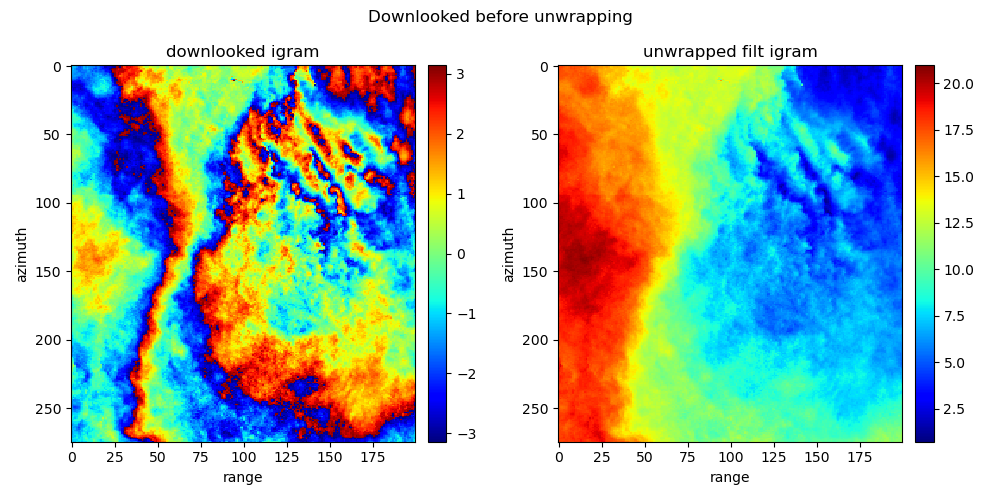

In [8]:
# now plot them.
fig = plt.figure(figsize=(10,5),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.imshow(np.fliplr(dl_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('downlooked igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(1,2,2)
plt.imshow(np.fliplr(unwr_dl_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.suptitle('Downlooked before unwrapping')
plt.show()

Now need to upsample the downlooked unwrapped igram.

In [9]:
# reverse of downlook: uplook(?) upsample.
int_upsampled = np.ndarray((dy,dx),dtype='float')
for y in range(dydl):
    for x in range(dxdl):
        int_upsampled[y*alooks:(y+1)*alooks,x*rlooks:(x+1)*rlooks] = unwr_dl_igram[y,x]
print('igram upsampled.')

igram upsampled.


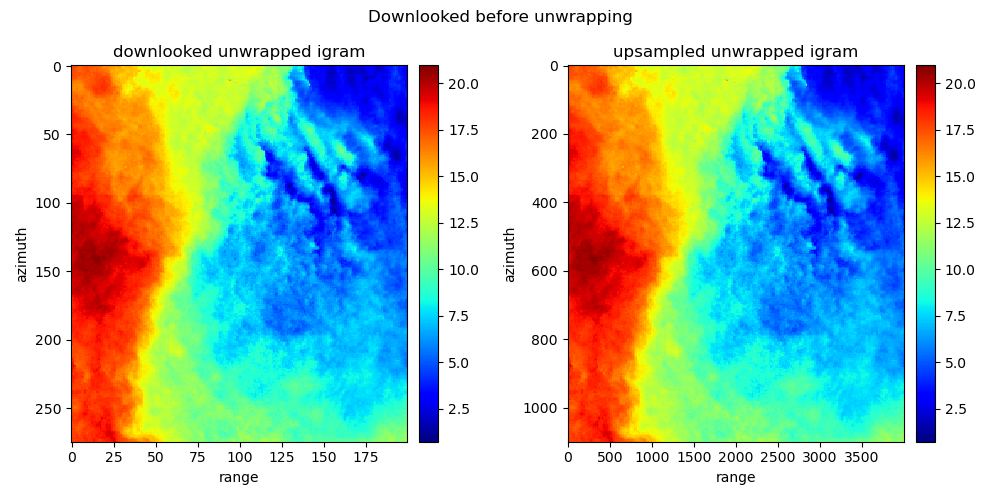

In [10]:

# plot them to make sure upsampling worked properly.
fig = plt.figure(figsize=(10,5),tight_layout='TRUE')
plt.subplot(1,2,1)
plt.imshow(np.fliplr(unwr_dl_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('downlooked unwrapped igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(1,2,2)
plt.imshow(np.fliplr(int_upsampled),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('upsampled unwrapped igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.suptitle('Downlooked before unwrapping')
plt.show()

Now plot them.

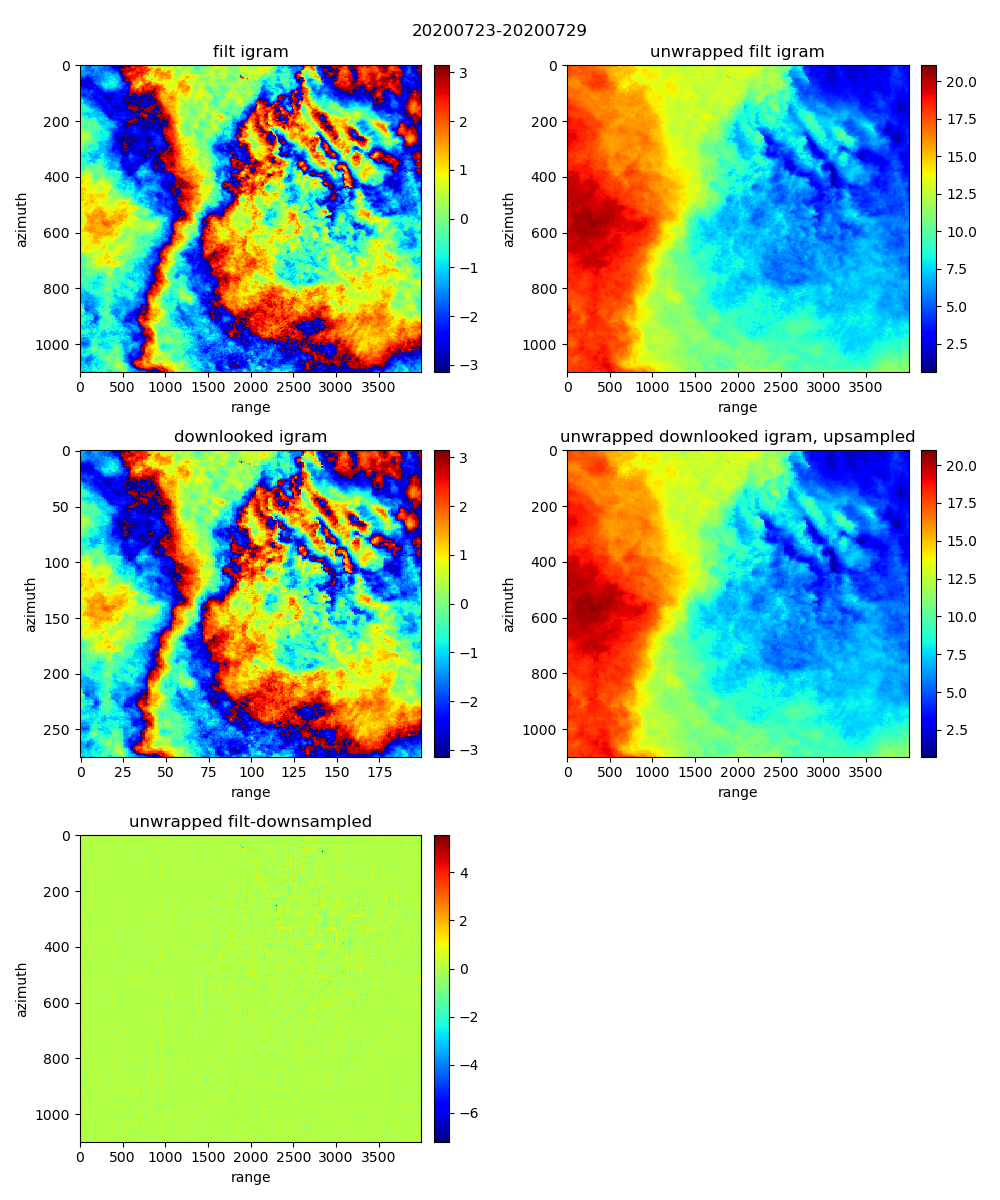

In [11]:
# now plot all versions
fig = plt.figure(figsize=(10,12),tight_layout='TRUE')
plt.subplot(3,2,1)
plt.imshow(np.fliplr(filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,2)
plt.imshow(np.fliplr(unwr_filt_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filt igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,3)
plt.imshow(np.fliplr(dl_igram),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('downlooked igram'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,4)
plt.imshow(np.fliplr(int_upsampled),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped downlooked igram, upsampled'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.subplot(3,2,5)
plt.imshow(np.fliplr(unwr_filt_igram-int_upsampled),aspect='auto',interpolation='nearest')
plt.colorbar(orientation='vertical',pad=0.03); plt.set_cmap('jet')
plt.title('unwrapped filt-downsampled'); plt.xlabel('range'); plt.ylabel('azimuth')
plt.suptitle(str(date1)+'-'+str(date2))
plt.show()